### A. Goldman, N. Puchkin, V. Shcherbakova, and U. Vinogradova

### Numerical experiments on artificial data sets, described in the paper
### "A Contrastive Approach to Online Change Point Detection" (arXiv:2206.10143)

In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import laplace
import pandas as pd
import matplotlib.pyplot as plt

# Import the algorithms for comparison
from algorithms.contrastive_change_point import compute_test_stat_linear
from algorithms.contrastive_change_point import compute_test_stat_nn
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd
from algorithms.cusum import compute_cusum

%matplotlib inline

np.random.seed(1)

### WISDM data set

In [2]:
# Read the data
df = pd.read_csv('data/WISDM/sample_0.csv')

# Feature vectors
X = np.array(df[['X1', 'X2', 'X3']])
print(X.shape)

# Labels
labels = np.array(df['Label'])
change_points = np.where(labels)[0]

(64868, 3)


In [3]:
# Data preprocessing
# Reduce the data, averaging over 20 values

bandwidth = 20
N = X.shape[0] // bandwidth

data = np.empty((0, 3))
new_labels = np.empty(0)

for t in range(N):
        
    data = np.append(data, np.mean(X[bandwidth * t : bandwidth * (t + 1)], axis=0).reshape(1, -1), axis=0)
    new_labels = np.append(new_labels, np.sum(labels[bandwidth * t : bandwidth * (t + 1)]))
    
change_points = np.where(new_labels)[0]
print(change_points)

[ 180  360  540  720  900 1080 1260 1440 1620 1801 1981 2161 2341 2521
 2702 2882 3063]


In [4]:
# Split the data into the stationary part, validation part, and test part

# Stationary part: three parts of the time series without the change points.
# Used to tune the threshold
#
data_stationary = [data[:180], data[181:360], data[361:540], data[541:720]]

# Validation part: a part with several change points to tune the hyperparameters
val_start = 0
val_end = 1670
data_val = data[val_start:val_end]

# Test part: check the performance of the procedures
test_start = 1670
test_end = 3060
data_test = data[test_start:test_end]

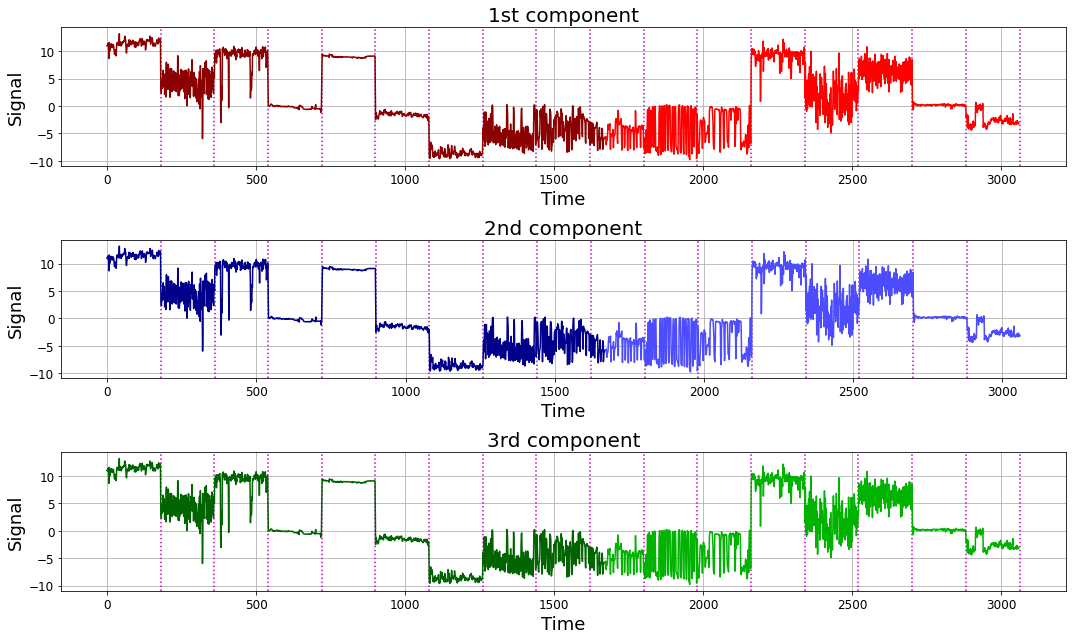

In [5]:
plt.figure(figsize=(15, 9))

plt.subplot(3, 1, 1)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(val_end), data[:val_end, 0], c='darkred')
plt.plot(np.arange(test_start, test_end), data[test_start:test_end, 0], c='r')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='1st component', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(3, 1, 2)

for i in range(len(change_points) - 1):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(val_end), data[:val_end, 0], c='darkblue')
plt.plot(np.arange(test_start, test_end), data[test_start:test_end, 0], c='#4d4dff')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='2nd component', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.subplot(3, 1, 3)

for i in range(len(change_points)):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(val_end), data[:val_end, 0], c='darkgreen')
plt.plot(np.arange(test_start, test_end), data[test_start:test_end, 0], c='#00b300')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='3rd component', fontsize=20)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Signal', fontsize=18)
plt.grid()

plt.tight_layout()
plt.savefig('images/WISDM.png')

In [6]:
z_lin = 28.072564631389547

p = 1

# Initialization of the test statistic
S_lin = np.empty(0)

# Initialization
st_lin = 0
new_st_lin = 0
    
while new_st_lin >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_lin, new_st_lin = compute_test_stat_linear(data_val[st_lin + 1:], p,\
                                                     design='multivariate', threshold=z_lin, delta_max=50)

    S_lin = np.append(S_lin, new_S_lin)
    
    if new_st_lin >= 0:
        st_lin += new_st_lin
        
    
st_lin = 0
new_st_lin = 0
    
while new_st_lin >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_lin, new_st_lin = compute_test_stat_linear(data_test[st_lin + 1:], p,\
                                                     design='multivariate', threshold=z_lin, delta_max=50)

    S_lin = np.append(S_lin, new_S_lin)
    
    if new_st_lin >= 0:
        st_lin += new_st_lin

In [7]:
z_nn = 5.595171984632453

# Initialization of the test statistic
S_nn = np.empty(0)

# Initialization
st_nn = 0
new_st_nn = 0
    
while new_st_nn >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_nn, new_st_nn = compute_test_stat_nn(data_val[st_nn + 1:], threshold=z_nn, n_epochs=20, delta_max=50)

    S_nn = np.append(S_nn, new_S_nn)

    if new_st_nn >= 0:
        st_nn += new_st_nn

st_nn = 0
new_st_nn = 0
    
while new_st_nn >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_nn, new_st_nn = compute_test_stat_nn(data_test[st_nn + 1:], threshold=z_nn, n_epochs=20, delta_max=50)

    S_nn = np.append(S_nn, new_S_nn)

    if new_st_nn >= 0:
        st_nn += new_st_nn

In [8]:
# Apply the fast change point detection procedure
z_ftal = 3.82
b = 2.5
p = 1

# Initialization of the test statistic
S_ftal = np.empty(0)

# Initialization
st_ftal = 0
new_st_ftal = 0
    
while new_st_ftal >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_val[st_ftal + 1:], p, beta=b,\
                                                       design='multivariate', threshold=z_ftal)

    S_ftal = np.append(S_ftal, new_S_ftal)

    if new_st_ftal >= 0:
        st_ftal += new_st_ftal
        
st_ftal = 0
new_st_ftal = 0
    
while new_st_ftal >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_test[st_ftal + 1:], p, beta=b,\
                                                       design='multivariate', threshold=z_ftal)

    S_ftal = np.append(S_ftal, new_S_ftal)

    if new_st_ftal >= 0:
        st_ftal += new_st_ftal

In [9]:
z_kliep = 1.1525948824041012
sigma = 20

# Initialization of the test statistic
S_kliep = np.empty(0)

# Initialization
st_kliep = 0
new_st_kliep = 0
    
while new_st_kliep >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_val[st_kliep + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z_kliep)

    S_kliep = np.append(S_kliep, new_S_kliep)

    if new_st_kliep >= 0:
        st_kliep += new_st_kliep

st_kliep = 0
new_st_kliep = 0

while new_st_kliep >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_test[st_kliep + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z_kliep)

    S_kliep = np.append(S_kliep, new_S_kliep)

    if new_st_kliep >= 0:
        st_kliep += new_st_kliep

In [10]:
z_mmd = 1.7284497814725275
sigma = 20

# Initialization of the test statistic
S_mmd = np.empty(0)

# Initialization
st_mmd = 0
new_st_mmd = 0
    
while new_st_mmd >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z_mmd)

    S_mmd = np.append(S_mmd, new_S_mmd)

    if new_st_mmd >= 0:
        st_mmd += new_st_mmd
        
st_mmd = 0
new_st_mmd = 0
    
while new_st_mmd >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_test[st_mmd + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z_mmd)

    S_mmd = np.append(S_mmd, new_S_mmd)

    if new_st_mmd >= 0:
        st_mmd += new_st_mmd

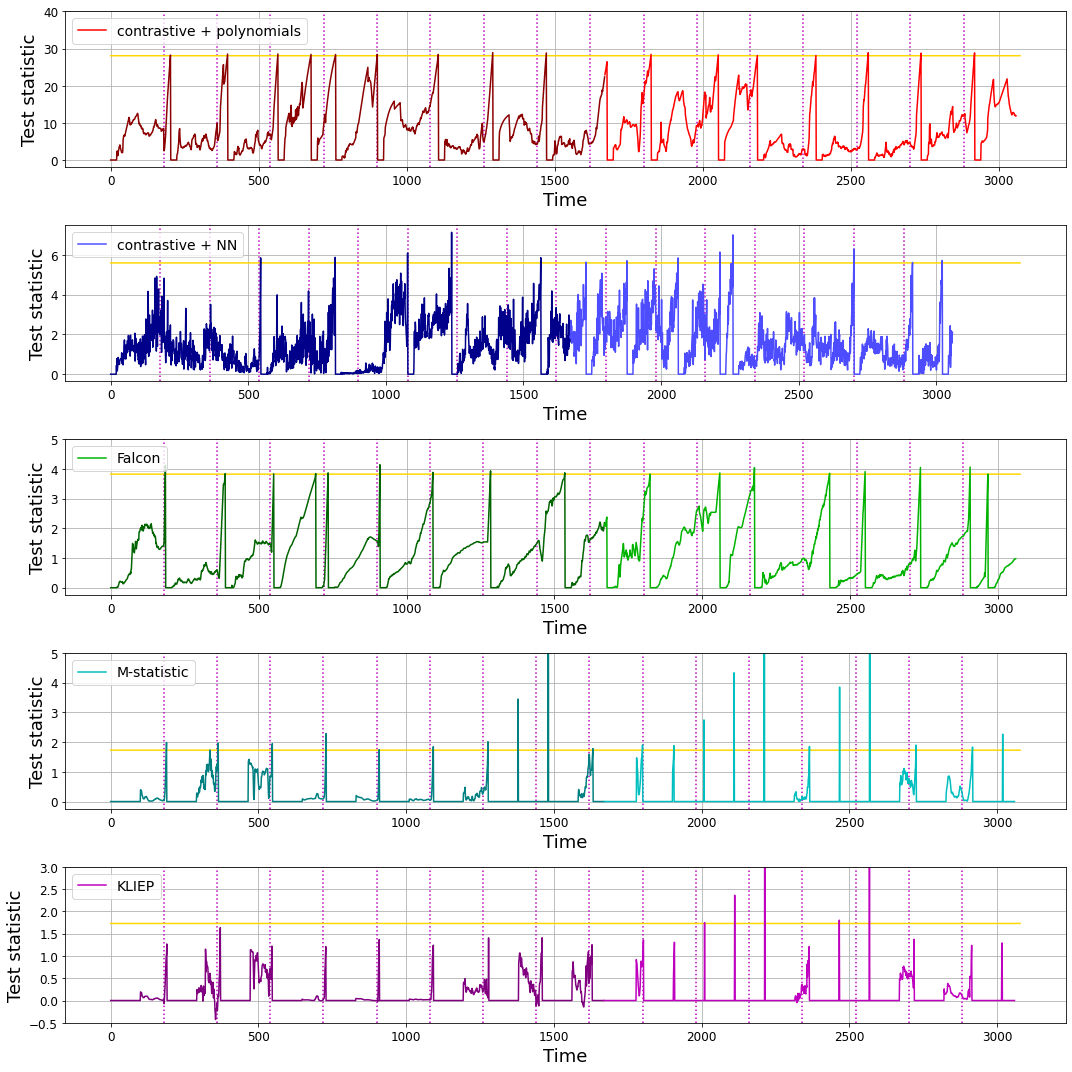

In [13]:
plt.figure(figsize=(15, 15))


plt.subplot(5, 1, 1)

for i in range(len(change_points) - 1):
    plt.axvline(change_points[i], c='m', ls=':')

plt.plot(np.arange(len(S_lin)), [z_lin] * len(S_lin), c='gold')
plt.plot(np.arange(val_end), S_lin[:val_end], c='darkred')
plt.plot(np.arange(test_start, test_end), S_lin[test_start:test_end], c='r', label='contrastive + polynomials')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Test statistic', fontsize=18)
plt.grid()
plt.ylim((-2, 40))

plt.subplot(5, 1, 2)

for i in range(len(change_points) - 1):
    plt.axvline(change_points[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_nn)), [z_nn] * len(S_nn), c='gold')
plt.plot(np.arange(val_end), S_nn[:val_end], c='darkblue')
plt.plot(np.arange(test_start, test_end), S_nn[test_start:test_end], c='#4d4dff', label='contrastive + NN')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Test statistic', fontsize=18)
plt.grid()

plt.subplot(5, 1, 3)

for i in range(len(change_points) - 1):
    plt.axvline(change_points[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_ftal)), [z_ftal] * len(S_ftal), c='gold')
plt.plot(np.arange(val_end), S_ftal[:val_end], c='darkgreen')
plt.plot(np.arange(test_start, test_end), S_ftal[test_start:test_end], c='#00b300', label='Falcon')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Test statistic', fontsize=18)
plt.ylim((-0.25, 5))
plt.grid()

plt.subplot(5, 1, 4)

for i in range(len(change_points) - 1):
    plt.axvline(change_points[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_mmd)), [z_mmd] * len(S_mmd), c='gold')
plt.plot(np.arange(val_end), S_mmd[:val_end], c='teal')
plt.plot(np.arange(test_start, test_end), S_mmd[test_start:test_end], c='c', label='M-statistic')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Test statistic', fontsize=18)
plt.ylim((-0.25, 5))
plt.grid()

plt.subplot(5, 1, 5)

for i in range(len(change_points) - 1):
    plt.axvline(change_points[i], c='m', ls=':')
    
plt.plot(np.arange(len(S_kliep)), [z_kliep] * len(S_kliep), c='gold')
plt.plot(np.arange(val_end), S_kliep[:val_end], c='purple')
plt.plot(np.arange(test_start, test_end), S_kliep[test_start:test_end], c='m', label='KLIEP')

plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time', fontsize=18)
plt.ylabel('Test statistic', fontsize=18)
plt.ylim((-0.5, 3))
plt.grid()

plt.tight_layout()

plt.savefig('images/WISDM_results.png')